<a href="https://colab.research.google.com/github/bilgeyucel/presentations/blob/main/aws-community-day-2024/extracting_structured_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Structured Output with Loop-Based Auto-Correction using Amazon Bedrock and Haystack (AWS Community Day Turkey 2024)

by Bilge Yucel [Twitter](https://twitter.com/bilgeycl), [Linkedin](https://www.linkedin.com/in/bilge-yucel/)

- **Level**: Intermediate
- **Time to complete**: 15 minutes
- **Prerequisites**: You must have credentials for [AmazonBedrock](https://docs.aws.amazon.com/bedrock/)
- **Components Used**: `PromptBuilder`, `AmazonBedrockGenerator`, `OutputValidator` (Custom component)

📚 Useful Resources
* [Documentation](https://docs.haystack.deepset.ai/docs?utm_campaign=developer-relations&utm_source=aws-day-turkey&utm_medium=colab)
* [GitHub Repo](https://github.com/deepset-ai/haystack)
* [Website](https://haystack.deepset.ai?utm_campaign=developer-relations&utm_source=aws-day-turkey&utm_medium=colab)

## Overview
This example demonstrates how to use Haystack's advanced [looping pipelines](https://docs.haystack.deepset.ai/docs/pipelines#loops) with LLMs for more dynamic and flexible data processing. You'll learn how to extract structured data from unstructured data using an LLM, and to validate the generated output against a predefined schema.

This tutorial uses Amazon Bedrock models to change unstructured passages into JSON outputs that follow the [Pydantic](https://github.com/pydantic/pydantic) schema. It uses a custom OutputValidator component to validate the JSON and loop back to make corrections, if necessary.

## Preparing the Colab Environment

## Installing Dependencies
Install `haystack-ai`, `amazon-bedrock-haystack` and [colorama](https://pypi.org/project/colorama/) with pip:

In [ ]:
%%bash

pip install haystack-ai amazon-bedrock-haystack
pip install colorama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.7 MB/s eta 0:00:00


## Defining a Schema to Parse the JSON Object

Define a simple JSON schema for the data you want to extract from a text passsage using the LLM. As the first step, define two [Pydantic models](https://docs.pydantic.dev/1.10/usage/models/), `City` and `CitiesData`, with suitable fields and types.

In [ ]:
from typing import List
from pydantic import BaseModel

class City(BaseModel):
    name: str
    country: str
    population: int


class CitiesData(BaseModel):
    cities: List[City]

> You can change these models according to the format you wish to extract from the text.

Then, generate a JSON schema from Pydantic models using `schema_json()`. You will later on use this schema in the prompt to instruct the LLM.

To learn more about the JSON schemas, visit [Pydantic Schema](https://docs.pydantic.dev/1.10/usage/schema/).  

In [ ]:
json_schema = CitiesData.schema_json(indent=2)

## Creating a Custom Component: OutputValidator

`OutputValidator` is a custom component that validates if the JSON object the LLM generates complies with the provided [Pydantic model](https://docs.pydantic.dev/1.10/usage/models/). If it doesn't, OutputValidator returns an error message along with the incorrect JSON object to get it fixed in the next loop.

For more details about custom components, see [Creating Custom Components](https://docs.haystack.deepset.ai/docs/custom-components).

In [ ]:
import json
import random
import pydantic
from pydantic import ValidationError
from typing import Optional, List
from colorama import Fore
from haystack import component

# Define the component input parameters
@component
class OutputValidator:
    def __init__(self, pydantic_model: pydantic.BaseModel):
        self.pydantic_model = pydantic_model
        self.iteration_counter = 0

    # Define the component output
    @component.output_types(valid_replies=List[str], invalid_replies=Optional[List[str]], error_message=Optional[str])
    def run(self, replies: List[str]):

        self.iteration_counter += 1

        ## Try to parse the LLM's reply ##
        # If the LLM's reply is a valid object, return `"valid_replies"`
        try:
            output_dict = json.loads(replies[0])
            self.pydantic_model.parse_obj(output_dict)
            print(
                Fore.GREEN
                + f"OutputValidator at Iteration {self.iteration_counter}: Valid JSON from LLM - No need for looping: {replies[0]}"
            )
            return {"valid_replies": replies}

        # If the LLM's reply is corrupted or not valid, return "invalid_replies" and the "error_message" for LLM to try again
        except (ValueError, ValidationError) as e:
            print(
                Fore.RED
                + f"OutputValidator at Iteration {self.iteration_counter}: Invalid JSON from LLM - Let's try again.\n"
                f"Output from LLM:\n {replies[0]} \n"
                f"Error from OutputValidator: {e}"
            )
            return {"invalid_replies": replies, "error_message": str(e)}

Then, create an OutputValidator instance with `CitiesData` that you have created before.

In [ ]:
output_validator = OutputValidator(pydantic_model=CitiesData)

## Creating the Prompt

Write instructions for the LLM for converting a passage into a JSON format. Ensure the instructions explain how to identify and correct errors if the JSON doesn't match the required schema. Once you create the prompt, initialize PromptBuilder to use it.  

For information about Jinja2 template and PromptBuilder, see [PromptBuilder](https://docs.haystack.deepset.ai/docs/promptbuilder).

In [ ]:
from haystack.components.builders import PromptBuilder

prompt_template = """
Create a JSON object from the information present in this passage: {{passage}}.
Only use information that is present in the passage. Follow this JSON schema, but only return the actual instances without any additional schema definition:
{{schema}}
Make sure your response is a dict and not a list.
{% if invalid_replies and error_message %}
  You already created the following output in a previous attempt: {{invalid_replies}}
  However, this doesn't comply with the format requirements from above and triggered this Python exception: {{error_message}}
  Correct the output and try again. Just return the corrected output without any extra explanations.
{% endif %}
"""
prompt_builder = PromptBuilder(template=prompt_template)

## Initalizing the Generator

Use [AmazonBedrockGenerator](https://docs.haystack.deepset.ai/docs/amazonbedrockgenerator) to generate
text using Amazon Bedrock's `amazon.titan-text-lite-v1` model.

In [ ]:
import os
from getpass import getpass

os.environ["AWS_ACCESS_KEY_ID"] = getpass("aws_access_key_id: ")
os.environ["AWS_SECRET_ACCESS_KEY"] = getpass("aws_secret_access_key: ")
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

aws_access_key_id: ··········
aws_secret_access_key: ··········


In [ ]:
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator

bedrock_model = 'amazon.titan-text-lite-v1' # @param ["amazon.titan-text-express-v1", "amazon.titan-text-lite-v1", "meta.llama3-8b-instruct-v1:0", "meta.llama3-70b-instruct-v1:0", "mistral.mixtral-8x7b-instruct-v0:1", "anthropic.claude-instant-v1", "anthropic.claude-v1", "anthropic.claude-v2","anthropic.claude-v2:1", "meta.llama2-13b-chat-v1", "meta.llama2-70b-chat-v1", "ai21.j2-mid-v1", "ai21.j2-ultra-v1"]
generator = AmazonBedrockGenerator(model=bedrock_model, max_length=3000)

## Building the Pipeline

Add all components to your pipeline and connect them. Add connections from `output_validator` back to the `prompt_builder` for cases where the produced JSON doesn't comply with the JSON schema. Set `max_loops_allowed` to avoid infinite looping.

In [ ]:
from haystack import Pipeline

pipeline = Pipeline(max_loops_allowed=5)

# Add components to your pipeline
pipeline.add_component(instance=prompt_builder, name="prompt_builder")
pipeline.add_component(instance=generator, name="llm")
pipeline.add_component(instance=output_validator, name="output_validator")

# Now, connect the components to each other
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_validator")
# If a component has more than one output or input, explicitly specify the connections:
pipeline.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
pipeline.connect("output_validator.error_message", "prompt_builder.error_message")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: AmazonBedrockGenerator
  - output_validator: OutputValidator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> output_validator.replies (List[str])
  - output_validator.invalid_replies -> prompt_builder.invalid_replies (Optional[List[str]])
  - output_validator.error_message -> prompt_builder.error_message (Optional[str])

### Visualize the Pipeline

To understand how you formed this pipeline with conditional routing, use [show()](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method of the pipeline:

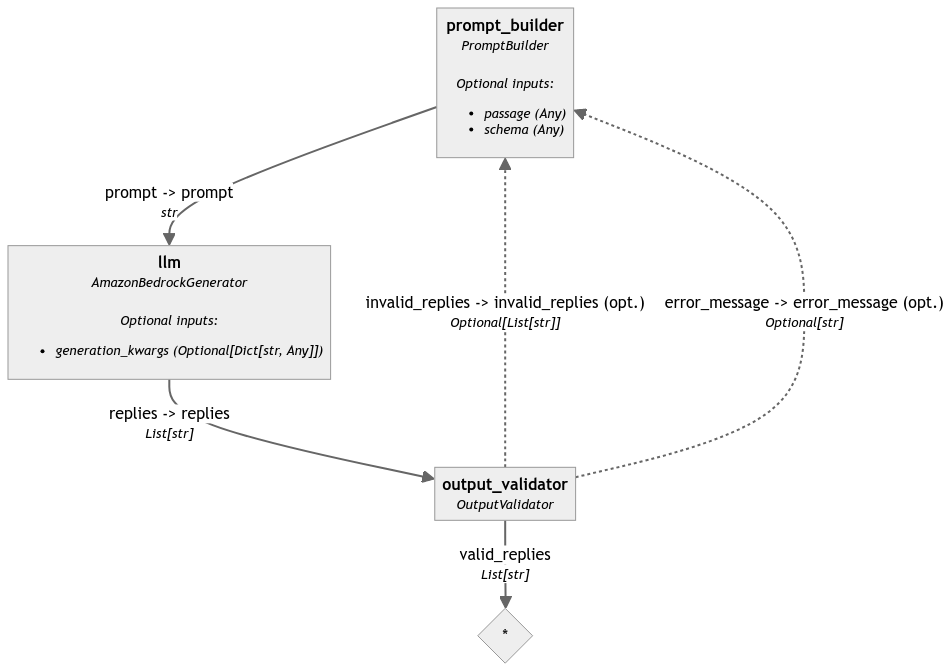

In [ ]:
pipeline.show()

## Testing the Pipeline

Run the pipeline with an example passage that you want to convert into a JSON format and the `json_schema` you have created for `CitiesData`. For the given example passage, the generated JSON object should be like:
```json
{
  "cities": [
    {
      "name": "Berlin",
      "country": "Germany",
      "population": 3850809
    },
    {
      "name": "Paris",
      "country": "France",
      "population": 2161000
    },
    {
      "name": "Lisbon",
      "country": "Portugal",
      "population": 504718
    }
  ]
}
```
The output of the LLM should be compliant with the `json_schema`. If the LLM doesn't generate the correct JSON object, it will loop back and try again.

In [ ]:
passage = "Berlin is the capital of Germany. It has a population of 3,850,809. Paris, France's capital, has 2.161 million residents. Lisbon is the capital and the largest city of Portugal with the population of 504,718."
result = pipeline.run({"prompt_builder": {"passage": passage, "schema": json_schema}})

OutputValidator at Iteration 1: Invalid JSON from LLM - Let's try again.
Output from LLM:
 ```
{
  "data": {
    "cities": [
      {
        "name": "Berlin",
        "population": 3850809,
        "country": "Germany"
      },
      {
        "name": "Paris",
        "population": 2161000,
        "country": "France"
      },
      {
        "name": "Lisbon",
        "population": 504718
      }
    ]
  }
}
``` 
Error from OutputValidator: Expecting value: line 1 column 1 (char 0)
OutputValidator at Iteration 2: Invalid JSON from LLM - Let's try again.
Output from LLM:
 ```
{
  "data": {
    "cities": [
      {
        "name": "Berlin",
        "population": 3850809,
        "country": "Germany"
      },
      {
        "name": "Paris",
        "population": 2161000,
        "country": "France"
      },
      {
        "name": "Lisbon",
        "population": 504718
      }
    ]
  }
}
``` 
Error from OutputValidator: Expecting value: line 1 column 1 (char 0)
OutputValidator at Iterati

PipelineMaxLoops: Maximum loops count (5) exceeded for component 'prompt_builder'

> If you encounter `PipelineMaxLoops: Maximum loops count (5) exceeded for component 'prompt_builder'.` error, consider increasing the maximum loop count or simply rerun the pipeline.

### Print the Correct JSON
If you didn't get any error, you can now print the corrected JSON.

In [ ]:
valid_reply = result["output_validator"]["valid_replies"][0]
valid_json = json.loads(valid_reply)
print(valid_json)

## What's next

🎉 Congratulations! You've built a system that generates structured JSON out of unstructured text passages, and auto-corrects it by using the looping functionality of Haystack pipelines.

To stay up to date on the latest Haystack developments, you can 🗞️ [subscribe to our newsletter](https://landing.deepset.ai/haystack-community-updates) and 👾[join Haystack discord community](https://discord.gg/haystack).

Thanks for reading!